# Improvements in this notebook

* Disintegrate **RF and RMC** on optimization
* Compare the Hyper-Heuristics Framework to:
  - Neural Networks (**NNs**).
  - Support Vector Machines (**SVMs**).
  - **Random Forests** or XGBoost.

# Step 1: Fetch and Prepare Data

Date
2014-12-12 00:00:00-05:00        0.00
2014-12-15 00:00:00-05:00        0.00
2014-12-16 00:00:00-05:00        0.00
2014-12-17 00:00:00-05:00        0.00
2014-12-18 00:00:00-05:00        0.00
                               ...   
2024-12-05 00:00:00-05:00    18552.71
2024-12-06 00:00:00-05:00    18568.93
2024-12-09 00:00:00-05:00    18585.15
2024-12-10 00:00:00-05:00    18601.37
2024-12-11 00:00:00-05:00    18617.59
Length: 2516, dtype: float64
Date
2014-12-12 00:00:00-05:00     0.00
2014-12-15 00:00:00-05:00     0.00
2014-12-16 00:00:00-05:00     0.00
2014-12-17 00:00:00-05:00     0.00
2014-12-18 00:00:00-05:00     0.00
                             ...  
2024-12-05 00:00:00-05:00    16.22
2024-12-06 00:00:00-05:00    16.22
2024-12-09 00:00:00-05:00    16.22
2024-12-10 00:00:00-05:00    16.22
2024-12-11 00:00:00-05:00    16.22
Name: Dividends, Length: 2516, dtype: float64


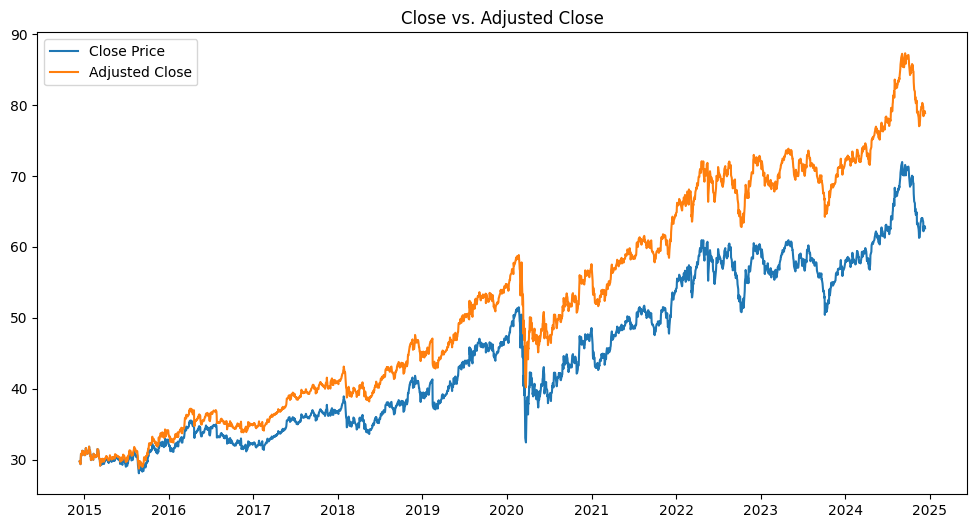

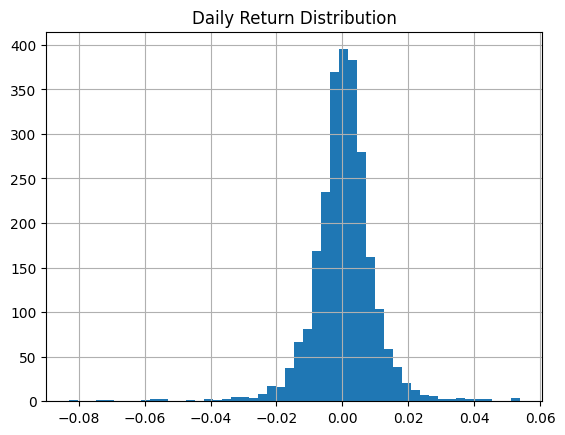

In [ ]:
# Import required libraries
!pip install deap
import yfinance as yf
import pandas as pd
import re
import random
import numpy as np
from deap import base, algorithms, creator, tools, gp
import operator
import math
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import itertools
import graphviz

ticker = "KO"
data = yf.Ticker(ticker).history(period="10y")

# Adjust Daily Returns with Dividends
data['Adjusted Close'] = data['Close'] + data['Dividends'].cumsum()
data['Daily Return'] = data['Adjusted Close'].pct_change()

print((data['Adjusted Close'] - data['Close']).cumsum())
print(data['Dividends'].cumsum())

plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label="Close Price")
plt.plot(data['Adjusted Close'], label="Adjusted Close")
plt.legend()
plt.title("Close vs. Adjusted Close")
plt.show()

data['Daily Return'].hist(bins=50)
plt.title("Daily Return Distribution")
plt.show()

# Step 2: Define Target Function

In [ ]:
# Parameters for Moving Averages and Threshold
short_window = 30  # Short-term moving average window
long_window = 50   # Long-term moving average window
threshold = 0.001  # 0.1% threshold for significant price change

# Calculate Moving Averages
data['Short_MA'] = data['Close'].rolling(window=short_window).mean()
data['Long_MA'] = data['Close'].rolling(window=long_window).mean()

# Identify Trends Using Moving Averages
data['Trend'] = np.where(data['Short_MA'] > data['Long_MA'], 1, -1)  # 1 for uptrend, -1 for downtrend

# Calculate Percentage Price Change
data['Price_Change'] = (data['Close'].shift(-1) - data['Close']) / data['Close']

# Define Target Using Trend and Threshold
data['Target'] = np.where(
    (data['Trend'] == 1) & (data['Price_Change'] > threshold), 1,   # Buy signal for uptrend and significant price increase
    np.where(
        (data['Trend'] == -1) & (data['Price_Change'] < -threshold), -1,  # Sell signal for downtrend and significant price decrease
        0  # Hold for small changes or conflicting signals
    )
)

# Calculate naive strategy metrics
data['Target Return'] = data['Target'].shift(1) * data['Daily Return']
data['Target Cumulative Return'] = (1 + data['Target Return']).cumprod()

# Drop rows with NaN values (resulting from moving averages)
data.dropna(inplace=True)

# Step 3: Define all indicator functions and operators

In [ ]:
# Momentum
def momentum(data, period):
    return data['Close'].diff(period)

# Moving Average
def moving_average(data, period):
    return data['Close'].rolling(window=period).mean()

# Volatility (e.g., Standard Deviation)
def volatility(data, period):
    return data['Close'].rolling(window=period).std()

# RSI
def rsi(data, period):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# MACD
def macd(data, short_period, long_period, signal_period):
    short_ma = data['Close'].ewm(span=short_period, adjust=False).mean()
    long_ma = data['Close'].ewm(span=long_period, adjust=False).mean()
    macd_line = short_ma - long_ma
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

# ATR
def atr(data, period):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    tr = high_low.combine(high_close, max).combine(low_close, max)
    return tr.rolling(window=period).mean()

# Williams %R
def williams(data, period):
    highest_high = data['High'].rolling(window=period).max()
    lowest_low = data['Low'].rolling(window=period).min()
    return -100 * ((highest_high - data['Close']) / (highest_high - lowest_low))

# Bollinger Bands
def bollinger_bands(data, period, std_dev_multiplier):
    ma = data['Close'].rolling(window=period).mean()
    std_dev = data['Close'].rolling(window=period).std()
    upper_band = ma + std_dev_multiplier * std_dev
    lower_band = ma - std_dev_multiplier * std_dev
    return upper_band, lower_band

# ADX
def adx(data, period):
    plus_dm = data['High'].diff().clip(lower=0)
    minus_dm = data['Low'].diff().clip(upper=0).abs()
    tr = atr(data, period)
    plus_di = 100 * (plus_dm.rolling(window=period).sum() / tr)
    minus_di = 100 * (minus_dm.rolling(window=period).sum() / tr)
    dx = (np.abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    return dx.rolling(window=period).mean()

# CMF
def cmf(data, period):
    money_flow_multiplier = ((data['Close'] - data['Low']) - (data['High'] - data['Close'])) / (data['High'] - data['Low'])
    money_flow_volume = money_flow_multiplier * data['Volume']
    return money_flow_volume.rolling(window=period).sum() / data['Volume'].rolling(window=period).sum()

#Define feature set with parameter ranges
feature_set = {
    'momentum': {'function': momentum, 'params': {'period': [5, 10, 20]}},
    'moving_average': {'function': moving_average, 'params': {'period': [10, 20, 50]}},
    'volatility': {'function': volatility, 'params': {'period': [10, 20, 50]}},
    'rsi': {'function': rsi, 'params': {'period': [14, 20, 30]}},
    'macd': {'function': macd, 'params': {'short_period': [10, 12, 14], 'long_period': [26, 30, 40], 'signal_period': [9, 10, 12]}},
    'atr': {'function': atr, 'params': {'period': [10, 14, 20]}},
    'williams': {'function': williams, 'params': {'period': [10, 14, 20]}},
    'bollinger_bands': {'function': bollinger_bands, 'params': {'period': [20, 30], 'std_dev_multiplier': [2, 2.5, 3]}},
    'adx': {'function': adx, 'params': {'period': [14, 20, 30]}},
    'cmf': {'function': cmf, 'params': {'period': [20, 30, 40]}}
}


def random_params(params):
    return {key: random.choice(values) for key, values in params.items()}

feature_params_mapping = {}

def apply_indicator(indicator, data, params):
    function = feature_set[indicator]['function']
    result = function(data, **params)

    # Store parameters in the mapping
    feature_params_mapping[indicator] = params

    # If the indicator returns multiple outputs, make sure they are stacked as columns
    if isinstance(result, tuple):
        # Stack tuple elements horizontally if they have the same number of rows
        if len(result[0]) == len(data):
            return np.column_stack(result)
        else:  # Handles cases where elements have different lengths, like macd
            return result[0] # Return only the first element
    else:
        return result

# Print function with parameters
def print_function_with_params(individual):
    # Get the function expression
    func_expr = str(individual)

    # Traverse the expression to find features
    for feature_name in feature_set:
        if feature_name in func_expr:
            # Retrieve parameters for the feature
            params = feature_params_mapping.get(feature_name, {})  # Handle missing features gracefully
            print(f"Feature: {feature_name}, Parameters: {params}")

    print(f"Function: {func_expr}")

# Precompute Indicators
precomputed_features = []
for i, indicator in enumerate(feature_set):
    # Generate all parameter combinations
    param_combinations = [dict(zip(feature_set[indicator]['params'], values))
                         for values in itertools.product(*feature_set[indicator]['params'].values())]

    for params in param_combinations:  # Iterate through combinations
        precomputed_features.append(apply_indicator(indicator, data, params))

        # Print feature name with number and parameters
        print(f"Feature {len(precomputed_features)}: {indicator}, Parameters: {params}")


features = np.column_stack(precomputed_features)  # Combine all features

pset = gp.PrimitiveSet("MAIN", len(features[0]))
print(len(features[0]))
# Map features to terminals
for i in range(len(features[0])):
    pset.renameArguments(**{f'ARG{i}': f'Feature_{i}'})

# Add operators
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)

# Handle safe division
def safe_div(left, right):
    return left / right if abs(right) > 1e-6 else 1
pset.addPrimitive(safe_div, 2)

def safe_power(a, b):
    return abs(a) ** b if (b >= 0 and b < 10 and a > -1000 and a < 1000) else a * b
pset.addPrimitive(safe_power, 2)

def safe_sqrt(a):
    return math.sqrt(a) if a >= 0 else a
pset.addPrimitive(safe_sqrt, 1)

def safe_exp(x):
    return np.exp(x) if -10 < x < 10 else x  # Avoid overflow
pset.addPrimitive(safe_exp, 1)

def safe_log(a):
    return math.log(abs(a)) if abs(a) > 0 else a
pset.addPrimitive(safe_log, 1)

pset.addPrimitive(math.sin, 1)

pset.addPrimitive(math.cos, 1)

def mean(a, b):
    return (a + b) / 2
pset.addPrimitive(mean, 2)

def stddev(a, b):
    return math.sqrt(((a - b) ** 2) / 2)
pset.addPrimitive(stddev, 2)

def clamp(a, min_val=-1, max_val=1):
    return max(min(a, max_val), min_val)
pset.addPrimitive(clamp, 1)

def compare(a, b, threshold=0.01):  # Example threshold
    diff = a - b
    if diff > threshold:
        return 1
    elif diff < -threshold:
        return -1
    else:
        return 0
pset.addPrimitive(compare, 3)  # Three arguments: a, b, and threshold

# Add constants
pset.addEphemeralConstant("rand101", partial(np.random.randint, -100, 100))

Feature 1: momentum, Parameters: {'period': 5}
Feature 2: momentum, Parameters: {'period': 10}
Feature 3: momentum, Parameters: {'period': 20}
Feature 4: moving_average, Parameters: {'period': 10}
Feature 5: moving_average, Parameters: {'period': 20}
Feature 6: moving_average, Parameters: {'period': 50}
Feature 7: volatility, Parameters: {'period': 10}
Feature 8: volatility, Parameters: {'period': 20}
Feature 9: volatility, Parameters: {'period': 50}
Feature 10: rsi, Parameters: {'period': 14}
Feature 11: rsi, Parameters: {'period': 20}
Feature 12: rsi, Parameters: {'period': 30}
Feature 13: macd, Parameters: {'short_period': 10, 'long_period': 26, 'signal_period': 9}
Feature 14: macd, Parameters: {'short_period': 10, 'long_period': 26, 'signal_period': 10}
Feature 15: macd, Parameters: {'short_period': 10, 'long_period': 26, 'signal_period': 12}
Feature 16: macd, Parameters: {'short_period': 10, 'long_period': 30, 'signal_period': 9}
Feature 17: macd, Parameters: {'short_period': 10, 

# Step 4: Define the GP functions

In [ ]:
if "FitnessMulti" in creator.__dict__:
    del creator.FitnessMulti
if "Individual" in creator.__dict__:
    del creator.Individual

creator.create("FitnessMulti", base.Fitness, weights=(0.75, 2.0, -0.75, -1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=4)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("compile", gp.compile, pset=pset)

# Step 4: Genetic Operators
def cxOnePointLeafBiased(ind1, ind2):
    """Executes a one point crossover on the input :class:`~deap.gp.PrimitiveTree` individuals. The
    crossover point is chosen among the nodes or leaves of the first individual
    randomly.

    :param ind1: The first individual participating in the crossover.
    :param ind2: The second individual participating in the crossover.
    :returns: A tuple of two individuals.

    This function uses the :func:`~deap.tools.cxOnePoint` function from the
    :mod:`~deap.tools` module.
    """
    if len(ind1) < 2 or len(ind2) < 2:
        # No crossover on small trees
        return ind1, ind2

    # Use the built-in cxOnePoint function to ensure valid trees:
    # This function handles the complexities of tree structure and arity
    return gp.cxOnePoint(ind1, ind2)

toolbox.register("mate", cxOnePointLeafBiased)


def mutate_feature_string(individual_str, features, indpb):
    """
    Mutates Feature_X terminals in the string representation of the individual.
    :param individual_str: String representation of the GP tree.
    :param features: Precomputed feature matrix.
    :param indpb: Probability of mutation for each feature.
    :return: Mutated string representation.
    """
    # Find all features in the string
    feature_matches = re.findall(r'\bFeature_\d+\b', individual_str)
    mutated_str = individual_str

    for feature in feature_matches:
        if random.random() <= indpb:
            current_feature_index = int(feature.split('_')[1])
            new_feature_index = random.randint(0, 56)

            # Replace the feature in the string
            mutated_str = re.sub(rf'\b{feature}\b', f"Feature_{new_feature_index}", mutated_str)

    return mutated_str


def rebuild_individual_from_string(mutated_str, pset):
    """
    Rebuilds an individual from its string representation.
    :param mutated_str: Mutated string representation of the GP tree.
    :param pset: Primitive set used to define the GP algorithm.
    :return: Rebuilt individual.
    """
    return gp.PrimitiveTree.from_string(mutated_str, pset)

def mutate_individual_with_string(individual, pset, features, indpb):
    """
    Mutate an individual by modifying its string representation.
    :param individual: The GP tree (individual) to mutate.
    :param pset: Primitive set used to define the GP algorithm.
    :param features: Precomputed feature matrix.
    :param indpb: Probability of mutating each terminal.
    :return: Mutated individual.
    """
    # Extract the string representation
    individual_str = str(individual)

    # Mutate the string
    mutated_str = mutate_feature_string(individual_str, features, indpb)

    # Rebuild the individual
    mutated_individual = rebuild_individual_from_string(mutated_str, pset)

    mutated_individual.fitness = creator.FitnessMulti() # Initialize the fitness attribute
    mutated_individual.fitness.values = (-1,0,0,0)

    return mutated_individual


# Register the custom mutation function
toolbox.register("mutate", mutate_individual_with_string, pset=pset, features=features, indpb=0.2)

# Step 5: Define Fitness Function

In [ ]:
#Initialize columns
data['Prediction'] = data['Open']
data['Strategy Return'] = data['Open']
data['Cumulative Return'] = data['Open']
data['Drawdown'] = data['Open']
data['Rolling Max'] = data['Open']

trades = []

# Helper functions for vectorized evaluation
def calculate_sharpe(strategy_return, risk_free_rate=0.01):
    """
    Calculate the Sharpe ratio for a given strategy return.

    Parameters:
    - strategy_return: Pandas Series or array of strategy returns.
    - risk_free_rate: Risk-free rate used in Sharpe ratio calculation.

    Returns:
    - Sharpe Ratio: Float representing the risk-adjusted return.
    """
    # Calculate average return and standard deviation of returns
    avg_return = strategy_return.mean() #- risk_free_rate #excluding risk free rate because sharpe is just used for comparison
    std_dev = strategy_return.std()

    # Avoid divide-by-zero errors
    if std_dev == 0:
        return 0

    # Calculate Sharpe Ratio
    sharpe_ratio = avg_return / std_dev
    return sharpe_ratio

def calculate_max_drawdown(data, predictions):
    data.loc[:, 'Strategy Return'] = predictions * data['Close'].pct_change()
    data.loc[:, 'Cumulative Return'] = (1 + data['Strategy Return']).cumprod()
    data.loc[:, 'Rolling Max'] = data['Cumulative Return'].cummax()
    data.loc[:, 'Drawdown'] = data['Cumulative Return'] / data['Rolling Max'] - 1
    return data['Drawdown'].min()

def calculate_accuracy(data_split, predictions):
    return sum(predictions == data_split['Target']) / len(data_split['Target'])

def calculate_rate_of_missing_chances(data_split, predictions):
    # Ensure predictions and data_split['Target'] are NumPy arrays for element-wise comparison
    predictions = np.array(predictions)
    target_values = np.array(data_split['Target'])

    # Perform element-wise comparison and sum the True values
    missed_chances = np.sum((predictions != 1) & (target_values == 1))

    return missed_chances / len(data_split['Target'])

def calculate_rate_of_failure(data_split, predictions):
    # Ensure predictions and data_split['Target'] are NumPy arrays for element-wise comparison
    predictions = np.array(predictions)
    target_values = np.array(data_split['Target'])

    # Perform element-wise comparison and sum the True values
    failure_count = np.sum((predictions == 1) & (target_values != 1))

    return failure_count / len(data_split['Target'])

def calculate_individual_complexity(individual):
    return math.log(len(individual)) + individual.height

# Vectorized Fitness Function with Expanding Window, Hold Option, Transaction Costs, and Trade Penalty
def fitness_function(individual, transaction_cost=0.001, min_trades=5, max_trades=1500):
    """
    Fitness function using expanding window for evaluation.
    Includes:
    - Hold signals to reduce excessive trading.
    - Transaction costs for each trade.
    - Penalty for strategies that never or rarely trade.
    Evaluates individuals based on:
    - Accuracy
    - Sharpe Ratio (risk-adjusted returns)
    - Maximum Drawdown (penalizing large losses)
    - Model complexity (penalizing overly complex trees)
    """
    func = toolbox.compile(expr=individual)
    all_strategy_returns = []  # To collect returns across all windows
    all_trades = []  # To collect trades count
    train_accuracies = []
    train_rmcs = []
    train_rfs = []
    test_accuracies = []
    test_rmcs = []
    test_rfs = []

    # Expanding window loop
    split_point = int(len(data) * 0.2)  # Start testing after 20% of the dataset
    for test_start in range(split_point, len(data) - int(len(data) * 0.1), int(len(data) * 0.1)):
        train_data = data.iloc[:test_start].dropna()  # Expanding training set
        test_end = test_start + int(len(data) * 0.1)  # Size of the test set
        test_data = data.iloc[test_start:test_end].dropna()

        def evaluate(data_split):
            """
            Apply the GP function on the dataset with hold and transaction costs.
            """
            # Use the integer location of each index value within the original data
            # index_values = data_split.index.get_indexer(data.index)  # Original line - commented out
            # Instead of the above approach, reset the index to avoid misalignment
            data_split = data_split.reset_index(drop=True) # Reset the index

            # Use integer indexing to access feature values
            feature_values = features[data_split.index]  # Simplified


            predictions = []
            for row in feature_values:
                prediction = func(*row)
                # Ensure prediction is a scalar
                prediction = float(prediction)  # Convert to scalar if necessary
                threshold_buy, threshold_sell = 0.01, -0.01
                if prediction > threshold_buy:
                    predictions.append(1)  # Buy
                elif prediction < threshold_sell:
                    predictions.append(-1)  # Sell
                else:
                    predictions.append(0)  # Hold
            return predictions

        # Evaluate on training and testing datasets
        train_predictions = evaluate(train_data)
        individual.preds = train_predictions
        test_predictions = evaluate(test_data)

        # Incorporate transaction costs into returns
        def calculate_strategy_return_with_costs(data_split, predictions):
            """
            Calculate strategy returns with transaction costs.
            """
            data_split = data_split.copy()  # Ensure a new copy is created

            # Ensure 'Prediction' column exists
            if 'Prediction' not in data_split.columns:
                data_split['Prediction'] = 0  # or any default value

            # Assign predictions to the correct slice of the DataFrame
            data_split.loc[data_split.index, 'Prediction'] = predictions
            data_split.loc[:, 'Prediction'].shift(1)  # Shift to prevent lookahead bias
            data_split.loc[:, 'Prediction'].fillna(0)  # Fill NaN (introduced by shift) with 0

            data_split.loc[:, 'Strategy Return'] = data_split['Prediction'] * data_split['Close'].pct_change()

            # Identify trades (changes in position)
            data_split.loc[:, 'Trades'] = data_split['Prediction'].diff().fillna(0).abs()

            # Apply transaction costs for each trade
            #data_split.loc[:, 'Strategy Return'] -= transaction_cost * data_split['Trades']

            return data_split['Strategy Return'], data_split['Trades'].sum()

        # Compute metrics for training data
        train_strategy_return, train_trades = calculate_strategy_return_with_costs(train_data, train_predictions)
        train_data.loc[:, 'Strategy Return'] = train_strategy_return
        train_accuracy = calculate_accuracy(train_data, train_predictions)
        train_rmc = calculate_rate_of_missing_chances(train_data, train_predictions)
        train_rf = calculate_rate_of_failure(train_data, train_predictions)

        # Compute metrics for testing data
        test_strategy_return, test_trades = calculate_strategy_return_with_costs(test_data, test_predictions)
        test_data.loc[:, 'Strategy Return'] = test_strategy_return
        test_accuracy = calculate_accuracy(test_data, test_predictions)
        test_rmc = calculate_rate_of_missing_chances(test_data, test_predictions)
        test_rf = calculate_rate_of_failure(test_data, test_predictions)

        # Append metrics
        train_accuracies.append(train_accuracy)
        train_rmcs.append(train_rmc)
        train_rfs.append(train_rf)
        test_accuracies.append(test_accuracy)
        test_rmcs.append(test_rmc)
        test_rfs.append(test_rf)

        # Append returns for global evaluation
        all_strategy_returns.append(train_strategy_return)
        all_strategy_returns.append(test_strategy_return)
        all_trades.extend([train_trades, test_trades])


    # Aggregate and normalize metrics
    avg_train_accuracy = np.nanmean(train_accuracies)
    avg_train_rmc = np.nanmean(train_rmcs)
    avg_train_rf = np.nanmean(train_rfs)
    avg_test_accuracy = np.nanmean(test_accuracies)
    avg_test_rmc = np.nanmean(test_rmcs)
    avg_test_rf = np.nanmean(test_rfs)

    # Combine all returns
    combined_returns = pd.concat(all_strategy_returns, ignore_index=True)

    avg_return = combined_returns.mean() - 0.01
    #print(f"Average Return: {avg_return:.6f}")

    std_dev = combined_returns.std()
    #print(f"Standard Deviation: {std_dev:.6f}")

    # Calculate Sharpe Ratio and Max Drawdown for all returns
    overall_sharpe = calculate_sharpe(combined_returns)

    cumulative_return = (1 + combined_returns).cumprod()
    rolling_max = cumulative_return.cummax()
    overall_drawdown = (cumulative_return / rolling_max - 1).min()
    total_trades = sum(all_trades)

    drawdown_penalty = abs(overall_drawdown)

    # Penalize tree complexity
    complexity_penalty = calculate_individual_complexity(individual)

    # Log intermediate metrics
    individual.train_accuracy = avg_train_accuracy
    individual.sharpe = overall_sharpe
    individual.drawdown = drawdown_penalty
    individual.complexity = complexity_penalty
    individual.train_rmc = avg_train_rmc
    individual.train_rf = avg_train_rf
    individual.test_accuracy = avg_test_accuracy
    individual.test_rmc = avg_test_rmc
    individual.test_rf = avg_test_rf

    if total_trades < min_trades or total_trades > max_trades:
      return -1, 0, 0, 0 # Penalize for insufficient trades (-1 for accuracy is always dominated)


    return avg_test_accuracy, overall_sharpe, drawdown_penalty, complexity_penalty

target = data['Target'].values

#toolbox.unregister("evaluate")
toolbox.register("evaluate", fitness_function)

#toolbox.unregister("select")
toolbox.register("select", tools.selSPEA2)

# Step 6: Initialize the population and define logbook

In [ ]:
# Append custom individuals
# Define custom strategies as strings
custom_strategies = [
    "sub(Feature_0, Feature_2)",  # difference between short-term and long-term momentum
    "sub(Feature_3, Feature_5)",  # difference between short-term and long-term moving averages
    "sub(Feature_10, Feature_2)",  # divergence between RSI and momentum for overbought/oversold detection
    "mul(Feature_42, Feature_1)",  # Combines stochastic oscillator (Williams %R) with momentum
    "safe_div(Feature_10, Feature_7)",  # volatility to normalize RSI
    "sub(Feature_54, Feature_2)",  # Combines volume and momentum for identifying divergence
    "add(sub(Feature_3, Feature_5), mul(Feature_10, Feature_2))",  # Combines trend-following (MA) with momentum (RSI)
    "mul(Feature_53, sub(Feature_3, Feature_5))",  # Weighs trend strength (ADX) against moving average crossover
    "compare(Feature_1, Feature_9, safe_exp(-0.5))", # Generates buy or sell signals when the momentum surpasses or falls below a relative RSI level
    "compare(Feature_5, add(Feature_41, Feature_52), 0.75)", # identify breakout points where moving averages exceed volatility-adjusted levels
    "sub(mean(Feature_4, Feature_9), Feature_39)", # Detects price levels where average trends and momentum diverge from volatility
    "mul(safe_div(Feature_21, Feature_9), Feature_1)", # Measures the momentum strength when MACD trends align with RSI movements
    "compare(Feature_8, safe_exp(add(Feature_0, Feature_9)), -0.3)", # Detects volatile periods where short-term momentum and RSI exceed expected ranges
    "add(mul(Feature_47, Feature_11), sub(Feature_36, Feature_39))", # Captures price extremes using Bollinger bands while factoring in momentum and volatility trends
    "compare(mean(Feature_51, Feature_45), Feature_0, safe_exp(-0.25))", # Measures trend strength and reversal signals relative to short-term momentum
    "compare(Feature_5, add(Feature_51, Feature_9), safe_exp(-0.3))", # Identifies long-term trend shifts when moving averages cross adjusted RSI levels
    "compare(Feature_7, mean(Feature_5, Feature_9), safe_exp(-0.1))", # Captures divergences between volatility and combined momentum/trend indicators
    "mul(safe_div(Feature_23, Feature_8), Feature_10)", # Evaluates strength of MACD signals under varying volatility conditions
]

# Convert to gp.PrimitiveTree objects
custom_individuals = [
    gp.PrimitiveTree.from_string(strategy, pset) for strategy in custom_strategies
]
for ind in custom_individuals:
    ind.fitness = creator.FitnessMulti() # Initialize the fitness attribute

def hill_climbing(individual, toolbox, max_iter=5):
    """Applies hill climbing to an individual."""
    current_ind = toolbox.clone(individual)

    # Evaluate the initial individual if it hasn't been evaluated yet
    if not current_ind.fitness.valid:
        current_ind.fitness.values = toolbox.evaluate(current_ind)

    current_fitness = current_ind.fitness.values[1]  # Using Sharpe Ratio
    for _ in range(max_iter):
        neighbor = toolbox.clone(current_ind)
        neighbor = toolbox.mutate(neighbor)

        del neighbor.fitness.values

        neighbor.fitness.values = toolbox.evaluate(neighbor)
        if neighbor.fitness.values[1] > current_fitness:
            print("Improved Sharpe:", neighbor.fitness.values[1] - current_fitness)
            current_ind = neighbor
            current_fitness = neighbor.fitness.values[1]

    return current_ind

def population_with_custom_and_hill_climbing(n, custom_individuals, toolbox):
    """Generates a population with custom individuals and hill climbing."""
    population = []
    for _ in range(n):
        individual = toolbox.individual()
        individual = hill_climbing(individual, toolbox)  # Apply hill climbing
        population.append(individual)
    population.extend(custom_individuals)
    return population

# Update toolbox registration
toolbox.register("population", population_with_custom_and_hill_climbing, n=200, custom_individuals=custom_individuals, toolbox=toolbox)

population = toolbox.population()

# Store the top 10 individuals
hof = tools.HallOfFame(10)

def population_diversity(population):
    """
    Calculate population diversity based on tree height.
    """
    structures = [str(ind) for ind in population]
    heights = []
    node_counts = []
    for ind in population:
        if isinstance(ind, gp.PrimitiveTree):  # Check if it's a tree
            heights.append(ind.height)
            node_counts.append(len(ind))
        else:  # If not, it's likely a single node
            heights.append(1)
            node_counts.append(1)
    unique_structures = len(set(structures)) / len(population)
    unique_heights = len(set(heights)) / len(population)
    unique_nodes = len(set(node_counts)) / len(population)

    return (unique_structures + unique_heights + unique_nodes) / 3

acc_stats = tools.Statistics(lambda ind: ind.fitness.values[0] if ind.fitness.values[0] > -1 else np.nan)
acc_stats.register("avg_accuracy", np.nanmean)
acc_stats.register("max_accuracy", np.nanmax)
sharpe_stats = tools.Statistics(lambda ind: ind.fitness.values[1] if ind.fitness.values[0] > -1 else np.nan)
sharpe_stats.register("max_sharpe", np.nanmax)
sharpe_stats.register("avg_sharpe", np.nanmean)
drawdown_stats = tools.Statistics(lambda ind: ind.fitness.values[2] if ind.fitness.values[0] > -1 else np.nan)
drawdown_stats.register("avg_drawdown", np.nanmean)
drawdown_stats.register("max_drawdown", np.nanmax)
drawdown_stats.register("min_drawdown", np.nanmin)
complexity_stats = tools.Statistics(lambda ind: ind.fitness.values[3] if ind.fitness.values[0] > -1 else np.nan)
complexity_stats.register("avg_complexity", np.nanmean)
complexity_stats.register("max_complexity", np.nanmax)
complexity_stats.register("min_complexity", np.nanmin)
rmc_stats = tools.Statistics(lambda ind: ind.test_rmc)
rmc_stats.register("avg_test_rmc", np.nanmean)
rmc_stats.register("max_test_rmc", np.nanmax)
rmc_stats.register("min_test_rmc", np.nanmin)
rf_stats = tools.Statistics(lambda ind: ind.test_rf)
rf_stats.register("avg_test_rf", np.nanmean)
rf_stats.register("max_test_rf", np.nanmax)
rf_stats.register("min_test_rf", np.nanmin)
train_acc_stats = tools.Statistics(lambda ind: ind.train_accuracy)
train_acc_stats.register("avg_train_accuracy", np.nanmean)
train_acc_stats.register("max_train_accuracy", np.nanmax)

# Remove 'gen' and 'nevals' from the header if they exist:
header = list(rf_stats.fields)
if "gen" in header:
    header.remove("gen")
if "nevals" in header:
    header.remove("nevals")

# Set the header for the combined statistics
rf_stats.header = tuple(header)  # Reassign the modified list

stats = tools.MultiStatistics(accuracy=acc_stats, sharpe=sharpe_stats, drawdown=drawdown_stats, complexity=complexity_stats, rmc=rmc_stats, rf=rf_stats, a_train=train_acc_stats)

# Add custom tracking for diversity
diversity_stats = tools.Statistics(population_diversity)
diversity_stats.register("diversity", population_diversity)
diversity_stats.header = diversity_stats.fields  # Change header

# Create a MultiStatistics object
combined_stats = tools.MultiStatistics(fitness=stats, diversity=diversity_stats)
# Remove 'gen' and 'nevals' from the header if they exist:
header = list(combined_stats.fields)
if "gen" in header:
    header.remove("gen")
if "nevals" in header:
    header.remove("nevals")

# Set the header for the combined statistics
combined_stats.header = tuple(header)  # Reassign the modified list

logbook = tools.Logbook()  # Create a logbook to store statistics
logbook.header = combined_stats.fields  # Set the header for the logbook

Improved Sharpe: 0.06801837970325383
Improved Sharpe: 0.03859814090910565
Improved Sharpe: 0.002452164892200053
Improved Sharpe: 0.0024149570118897554
Improved Sharpe: 0.0037686025368920545
Improved Sharpe: 0.002844636357982943
Improved Sharpe: 0.024652551777602574
Improved Sharpe: 0.006281658156876504
Improved Sharpe: 0.0037323962138788025
Improved Sharpe: 0.030305218958336114
Improved Sharpe: 0.00432391884402146
Improved Sharpe: 0.03617002926288298
Improved Sharpe: 0.024513620517721012
Improved Sharpe: 0.031800057504697575
Improved Sharpe: 0.012237585930735104
Improved Sharpe: 0.0474184945452387
Improved Sharpe: 0.00321836619077958
Improved Sharpe: 0.0016936725298077845
Improved Sharpe: 0.013506536033322369
Improved Sharpe: 0.02311837372080147
Improved Sharpe: 0.0035369431508652893
Improved Sharpe: 0.007214747642726605
Improved Sharpe: 0.030918260610352345
Improved Sharpe: 0.022139007348424083
Improved Sharpe: 0.0031789775062515124
Improved Sharpe: 0.02171354195087202
Improved Sharpe

# Step 7: Define the GP Algorithm and update mutate function

In [ ]:
def eaMuPlusLambdaWithHillClimbing(population, toolbox, mu, cxpb, mutpb, ngen,
                              stats=None, halloffame=None, verbose=__debug__):
    """This is the :math:`(\mu + \lambda)` evolutionary algorithm.

    :param population: A list of individuals.
    :param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution
                    operators.
    :param mu: The number of individuals to select for the next generation.
    :param cxpb: The probability that an offspring is produced by crossover.
    :param mutpb: The probability that an offspring is produced by mutation.
    :param ngen: The number of generation.
    :param stats: A :class:`~deap.tools.Statistics` object that is updated
                  inplace, optional.
    :param halloffame: A :class:`~deap.tools.HallOfFame` object that will
                       contain the best individuals, optional.
    :param verbose: Whether or not to log the statistics.
    :returns: The final population
    :returns: A class:`~deap.tools.Logbook` with the statistics of the
              evolution.

    The algorithm takes in a population and evolves it over several generations.
    At each generation, it selects *mu* individuals from the population and
    uses them to produce offspring. The offspring are then inserted
    into the population, and the process is repeated until the desired number
    of generations has been reached.

    :math:`(\mu + \lambda)` is an elitist algorithm, which means that the best
    individuals from each generation are always preserved. This ensures that
    the algorithm always makes progress towards the optimal solution.

    This function uses the :func:`~deap.tools.selBest`,
    :func:`~deap.tools.selTournament`, :func:`~deap.tools.varAnd`,
    :func:`~deap.tools.varOr`, :func:`~deap.algorithms.varEAsimple` and
    :func:`~deap.tools.Statistics` functions from the :mod:`~deap.tools` and
    :mod:`~deap.algorithms` modules.

    .. note::
        The algorithm can be easily modified to use different selection,
        crossover, and mutation operators by simply changing the parameters of
        the :class:`~deap.base.Toolbox`.
    """

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        # Ensure fit is a tuple and not empty before assignment
        if isinstance(fit, tuple) and len(fit) > 0:
            ind.fitness.values = fit
        else:
            # Handle the case where fit is not a suitable tuple
            # For example, you might assign a default fitness value:
            ind.fitness.values = (-1, 0, 0, 0, 0, 0)  # Or another appropriate default
            print("Warning: toolbox.evaluate returned an invalid fitness value for an individual:", fit)  # Print the returned value

    if halloffame is not None:
        halloffame.update(population)

    # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats is not None else {}  # Get the statistics
        logbook.record(gen=0, nevals=len(invalid_ind), **record)  # Use the current generation number 'gen'
        if verbose:
            print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Number of elite individuals to carry forward
        n_elites = 5
        elite_individuals = toolbox.select(individuals=population, k=n_elites)

        # Create offspring
        parents = toolbox.select(individuals=population, k=mu - n_elites)

        # Apply variation
        offspring = algorithms.varAnd(parents, toolbox, cxpb, mutpb)

        offspring = elite_individuals + offspring

        # Invalidate fitness after variation
        for ind in offspring:
            del ind.fitness.values

        # Evaluate offspring before hill climbing
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        invalid_ind_nevals = len(invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            if isinstance(fit, tuple) and len(fit) > 0:
                ind.fitness.values = fit
            else:
                ind.fitness.values = (-1.0, 0.0, 0.0, 0.0, 0.0, 0.0)
                print("Warning: toolbox.evaluate returned an invalid fitness value for an offspring individual:", fit)

        hill_climbing_nevals = 0  # Track number of evaluations in hill climbing
        hill_climbing_updates = 0  # Track number of hill climbing updates
        # Perform hill climbing on offspring
        for i, ind in enumerate(offspring):
            current_ind = toolbox.clone(ind)
            current_fitness = current_ind.fitness.values[1]  # Use sharpe for hill climbing
            hill_climbing_update = False

            for _ in range(4):  # Limit the number of hill climbing steps
                neighbor = toolbox.clone(current_ind)
                neighbor, = toolbox.mutate(neighbor)  # Apply mutation
                del neighbor.fitness.values  # Invalidate fitness after mutation

                # Evaluate the neighbor
                if not neighbor.fitness.valid:
                    neighbor.fitness.values = toolbox.evaluate(neighbor)
                    hill_climbing_nevals += 1

                # Update if neighbor is better
                if neighbor.fitness.values[1] > current_fitness:
                    hill_climbing_update = True
                    current_ind = neighbor
                    current_fitness = neighbor.fitness.values[0]

            if(hill_climbing_update):
                hill_climbing_updates += 1
            offspring[i] = current_ind  # Update offspring

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            # Ensure fit is a tuple and not empty before assignment
            if isinstance(fit, tuple) and len(fit) > 0:
                ind.fitness.values = fit
            else:
                # Handle the case where fit is not a suitable tuple
                # For example, you might assign a default fitness value:
                ind.fitness.values = (-1, 0, 0, 0, 0, 0)  # Or another appropriate default
                print("Warning: toolbox.evaluate returned an invalid fitness value for an individual:", fit)  # Print the returned value

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Dynamic population size adjustment
        if gen < ngen / 1.5:  # Increase population in early generations
            population_size = int(mu * (1 + gen / (ngen / 2))) + 70  # Gradually increase
        else:
            population_size = len(population)  # Maintain population size after 66% of ngen

        # Retain the best individuals up to the population size
        population[:] = toolbox.select(individuals=offspring + population, k=population_size)

        print("Population size:", len(population))

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats is not None else {}  # Get the statistics
        nevals = invalid_ind_nevals + hill_climbing_nevals
        logbook.record(gen=gen, nevals=nevals, **record)  # Use the current generation number 'gen'
        if verbose:
            print("Individuals updated by Hill Climbing:", hill_climbing_updates)
            print(logbook.stream)

    return population, logbook

def mutate_individual_with_tuple_return(individual, pset, features, indpb):
    """
    Mutate an individual by modifying its string representation.
    :param individual: The GP tree (individual) to mutate.
    :param pset: Primitive set used to define the GP algorithm.
    :param features: Precomputed feature matrix.
    :param indpb: Probability of mutating each terminal.
    :return: Mutated individual.
    """
    # Extract the string representation
    individual_str = str(individual)

    # Mutate the string
    mutated_str = mutate_feature_string(individual_str, features, indpb)

    # Rebuild the individual
    mutated_individual = rebuild_individual_from_string(mutated_str, pset)

    mutated_individual.fitness = creator.FitnessMulti() # Initialize the fitness attribute
    mutated_individual.fitness.values = (-1,0,0,0)

    return mutated_individual,


# Register the custom mutation function
toolbox.unregister("mutate")
toolbox.register("mutate", mutate_individual_with_tuple_return, pset=pset, features=features, indpb=0.6)

# Step 8: Run the genetic programming algorithm

In [ ]:
result, log = eaMuPlusLambdaWithHillClimbing(
    population, toolbox,
    mu=60, cxpb=0.6, mutpb=0.4,
    ngen=25, verbose=True,
    stats=combined_stats, halloffame=hof
)

                              	                                                                                                                                                                                                                   fitness                                                                                                                                                                                                                    
                              	----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
          diversity           	   	      	                           a_train

# Step 9: Backest the pareto front

In [ ]:
def backtest_strategy(strategy, i):
    predictions = []
    for row in features:
        prediction = strategy(*row)
        # Ensure prediction is a scalar
        prediction = float(prediction)  # Convert to scalar if necessary
        threshold_buy, threshold_sell = 0.01, -0.01
        if prediction > threshold_buy:
            predictions.append(1)  # Buy
        elif prediction < threshold_sell:
            predictions.append(-1)  # Sell
        else:
            predictions.append(0)  # Hold

    data['Prediction'] = pd.Series(predictions, index=data.index)
    data['Prediction'].shift(1)
    data['Prediction'].fillna(0)  # Fill NaN (introduced by shift) with 0
    data['Prediction'] = data['Prediction'].astype(int)  # Convert to integer type
    return (np.array(data['Prediction'] * data['Close'].pct_change()))

def calculate_sharpe_ratio(returns, risk_free_rate=0.0001):
    """
    Calculate the Sharpe Ratio for a strategy.

    Parameters:
        returns (list or np.array): Daily or periodic returns of the strategy.
        risk_free_rate (float): Daily Risk-free rate.

    Returns:
        float: Sharpe Ratio
    """
    excess_returns = np.array(returns)
    mean_excess_return = np.mean(excess_returns)

    std_dev_excess_return = np.std(excess_returns)
    if std_dev_excess_return == 0:  # Avoid division by zero
        return 0

    num_periods = len(excess_returns)
    annualization_factor = np.sqrt(num_periods)  # Assuming returns are daily

    return ((mean_excess_return - 0.0001) / std_dev_excess_return) * annualization_factor

def calculate_max_drawdown(equity_curve):
    """
    Calculate the Maximum Drawdown (MDD) of a strategy.

    Parameters:
        equity_curve (list or np.array): Portfolio values over time.

    Returns:
        float: Maximum Drawdown as a percentage (e.g., 0.2 = 20%).
    """
    equity_curve = np.array(equity_curve)
    peak = np.maximum.accumulate(equity_curve)
    drawdown = (peak - equity_curve) / peak
    max_drawdown = np.max(drawdown) - 1
    return max_drawdown

# Step 7: Backtest the Strategy

# Extract Pareto front from the final population
pareto_front = tools.sortNondominated(result, len(result), first_front_only=True)[0]

# Assuming 'data' is your DataFrame and 'Close' is the price column
prices = data['Close'].values

# Backtesting Pareto front
threshold_buy, threshold_sell = 0.01, -0.01
results = []
for i, individual in enumerate(pareto_front):
    # Compile individual
    strategy = toolbox.compile(expr=individual)

    # Backtest signals
    returns = backtest_strategy(strategy, (i+1))
    returns[np.isnan(returns)] = 1

    # Evaluate performance metrics
    sharpe = calculate_sharpe_ratio(returns, prices)
    drawdown = calculate_max_drawdown(returns)

    returns[0] = 0

    # Store results
    results.append({'strategy': f"Strategy {i+1}", 'Profit': (((1 + returns).cumprod())[-1] - 1),
                    'Sharpe': sharpe, 'Drawdown': drawdown})

# Display results
results_df = pd.DataFrame(results)
print(len(results_df))
print(results_df)

206
         strategy     Profit    Sharpe  Drawdown
0      Strategy 1  33.140857  3.970272  0.064408
1      Strategy 2  33.140857  3.970272  0.064408
2      Strategy 3   1.050620  1.433220  0.096725
3      Strategy 4   1.050620  1.433220  0.096725
4      Strategy 5   1.050620  1.433220  0.096725
..            ...        ...       ...       ...
201  Strategy 202   2.117633  1.788793  0.084355
202  Strategy 203   2.117633  1.788793  0.084355
203  Strategy 204  58.746442  4.387419  0.064796
204  Strategy 205  -0.995209 -4.066700  0.096725
205  Strategy 206  -0.989566 -3.221579  0.096725

[206 rows x 4 columns]


# Step 10: Select best individual

In [ ]:
# Sort by Profit and select the top row
best_strategy_row = results_df.sort_values(by="Sharpe", ascending=False).iloc[0]

# Extract the best strategy and its profit
best_strategy_name = best_strategy_row['strategy']
best_strategy_profit = best_strategy_row['Profit']
best_strategy_sharpe = best_strategy_row['Sharpe']
best_strategy_drawdown = best_strategy_row['Drawdown']

print(f"Best Strategy: {best_strategy_name}, Profit: {best_strategy_profit}, Sharpe: {best_strategy_sharpe}, Drawdown: {best_strategy_drawdown}")

# Access the corresponding individual from the Pareto front
best_strategy_index = int(best_strategy_name.split(" ")[1]) - 1  # Extract index from strategy name
best_strategy_individual = pareto_front[best_strategy_index]

Best Strategy: Strategy 58, Profit: 122.16889884702636, Sharpe: 5.029107896379248, Drawdown: 0.06440760988484495


# Step 11: Improve best individual with hill climbing

In [ ]:
print(str(best_strategy_individual))
def hill_climbing_best(individual, toolbox, max_iter=100):
    """Applies hill climbing to an individual."""
    current_ind = toolbox.clone(individual)

    # Evaluate the initial individual if it hasn't been evaluated yet
    if not current_ind.fitness.valid:
        current_ind.fitness.values = toolbox.evaluate(current_ind)

    current_fitness = current_ind.fitness.values[1]  # Using Sharpe Ratio for hill climbing

    for _ in range(max_iter):
        neighbor = toolbox.clone(current_ind)
        neighbor, = toolbox.mutate(neighbor)  # Apply mutation
        del neighbor.fitness.values  # Invalidate fitness after mutation

        # Evaluate the neighbor
        neighbor.fitness.values = toolbox.evaluate(neighbor)

        # Update if neighbor is better
        if neighbor.fitness.values[1] > current_fitness:
            print("Hill climbing improvement:",neighbor.fitness.values[1] - current_fitness)
            current_ind = neighbor
            current_fitness = neighbor.fitness.values[1]

    return current_ind

# After running the GP algorithm (eaMuPlusLambdaWithHillClimbing)
improved_ind = hill_climbing_best(best_strategy_individual, toolbox)  # Apply hill climbing

# Print the improved individual's fitness
print(str(improved_ind))
print("Improved individual fitness:", improved_ind.fitness.values)
# Compile individual
improved_strategy = toolbox.compile(expr=improved_ind)

# Backtest signals
improved_returns = backtest_strategy(improved_strategy, (i+1))
improved_returns[np.isnan(improved_returns)] = 1

# Evaluate performance metrics
prices = data['Close'].values
improved_sharpe = calculate_sharpe_ratio(improved_returns, prices)
print("Improved Sharpe Ratio:", improved_sharpe)

clamp(add(mul(Feature_7, Feature_1), safe_exp(Feature_1)))
clamp(add(mul(Feature_7, Feature_1), safe_exp(Feature_1)))
Improved individual fitness: (0.3546747967479675, 0.14245363028272845, 0.3698752708142419, 4.9459101490553135)
Improved Sharpe Ratio: 5.029107896379248


# Step 12: Visualize signals and performance of best function

<ipython-input-81-ccda36998a62>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Prediction'].fillna(0, inplace=True)  # Fill NaN (introduced by shift) with 0


Prediction
 1    1952
-1     487
 0      27
Name: count, dtype: int64
Trades: Prediction
 0.0    2263
-2.0      95
 2.0      92
 1.0      10
-1.0       5
Name: count, dtype: int64


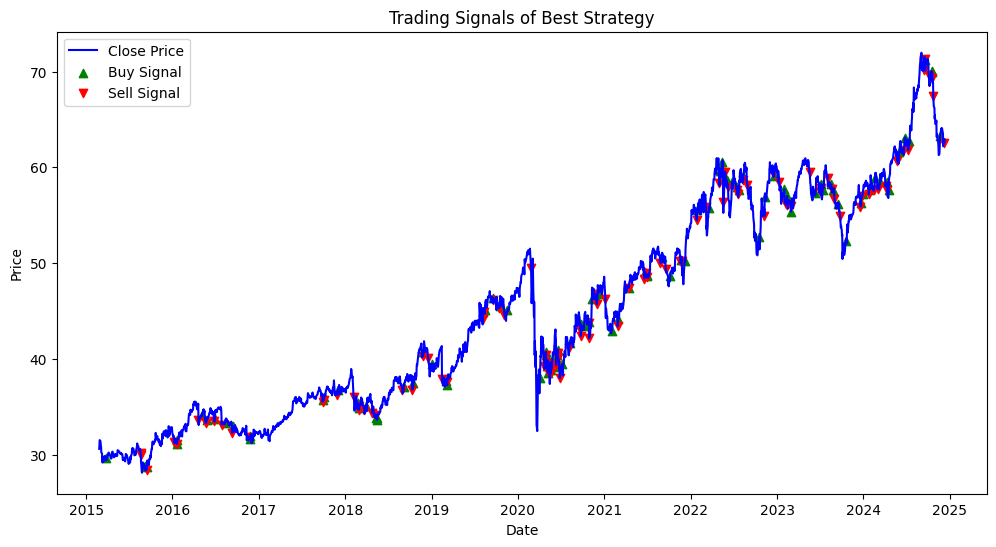

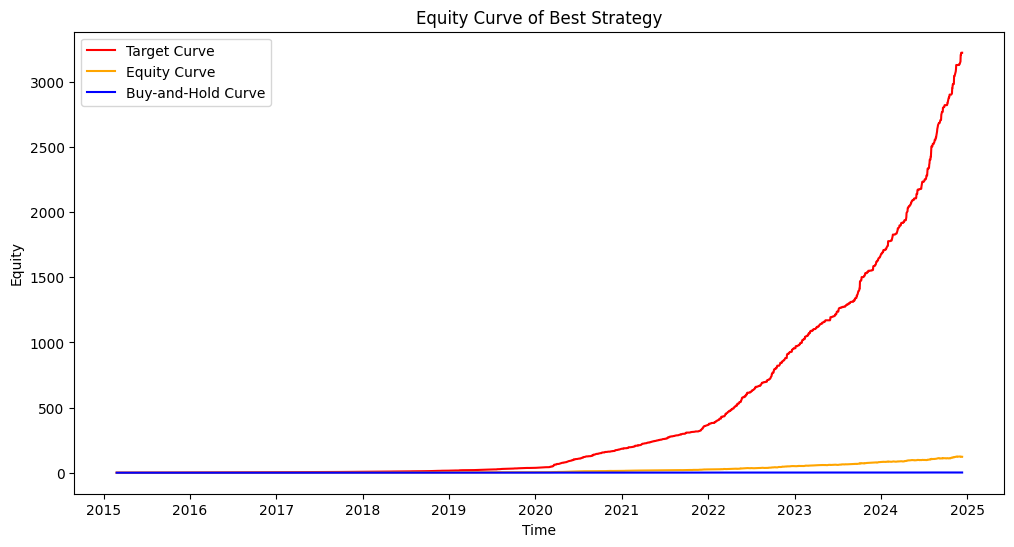

In [ ]:
best_strategy_function = toolbox.compile(expr=improved_ind)

threshold_buy, threshold_sell = 0.01, -0.01

predictions = []
for row in features:
    prediction = best_strategy_function(*row)
    # Ensure prediction is a scalar
    prediction = float(prediction)  # Convert to scalar if necessary
    threshold_buy, threshold_sell = 0.01, -0.01
    if prediction > threshold_buy:
        predictions.append(1)  # Buy
    elif prediction < threshold_sell:
        predictions.append(-1)  # Sell
    else:
        predictions.append(0)  # Hold

data['Prediction'] = pd.Series(predictions, index=data.index)
data['Prediction'].shift(1)
data['Prediction'].fillna(0, inplace=True)  # Fill NaN (introduced by shift) with 0
data['Prediction'] = data['Prediction'].astype(int)  # Convert to integer type
print(data['Prediction'].value_counts())
print("Trades:", data['Prediction'].diff().value_counts())

plot_df = data[['Close']].copy()  # Start with closing prices
plot_df['Signal'] = data[['Prediction']].diff().copy()  # Add the trading signals
# Add any other columns you want to visualize (e.g., indicators)

plt.figure(figsize=(12, 6))
plt.plot(plot_df['Close'], label='Close Price', color='blue')
plt.scatter(plot_df.index[plot_df['Signal'] > 0], plot_df['Close'][plot_df['Signal'] > 0], marker='^', color='green', label='Buy Signal')
#plt.scatter(plot_df.index[plot_df['Signal'] == 0], plot_df['Close'][plot_df['Signal'] == 0], marker='o', color='blue', label='No Signal')
plt.scatter(plot_df.index[plot_df['Signal'] < 0], plot_df['Close'][plot_df['Signal'] < 0], marker='v', color='red', label='Sell Signal')
plt.title('Trading Signals of Best Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

equity_curve = (np.array(data['Prediction'] * data['Close'].pct_change()))
equity_curve[np.isnan(equity_curve)] = 0
data.loc[:, 'Cumulative Return'] = (1 + equity_curve).cumprod()

data['Buy-and-Hold'] = data['Adjusted Close'] / data['Adjusted Close'].iloc[0]

plt.figure(figsize=(12, 6))
plt.plot(data['Target Cumulative Return'], label='Target Curve', color='red')
plt.plot(data['Cumulative Return'], label='Equity Curve', color='orange')
plt.plot(data['Buy-and-Hold'], label='Buy-and-Hold Curve', color='blue')
plt.title('Equity Curve of Best Strategy')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.legend()
plt.show()

# Step 13: Backtest on whole Data

<ipython-input-82-652c6aeaabd8>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Prediction'].fillna(0, inplace=True)  # Fill NaN (introduced by shift) with 0


Prediction
 1    14928
-1      881
 0       36
Name: count, dtype: int64
Trades: Prediction
 0.0    15460
-2.0      176
 2.0      175
 1.0       17
-1.0       16
Name: count, dtype: int64


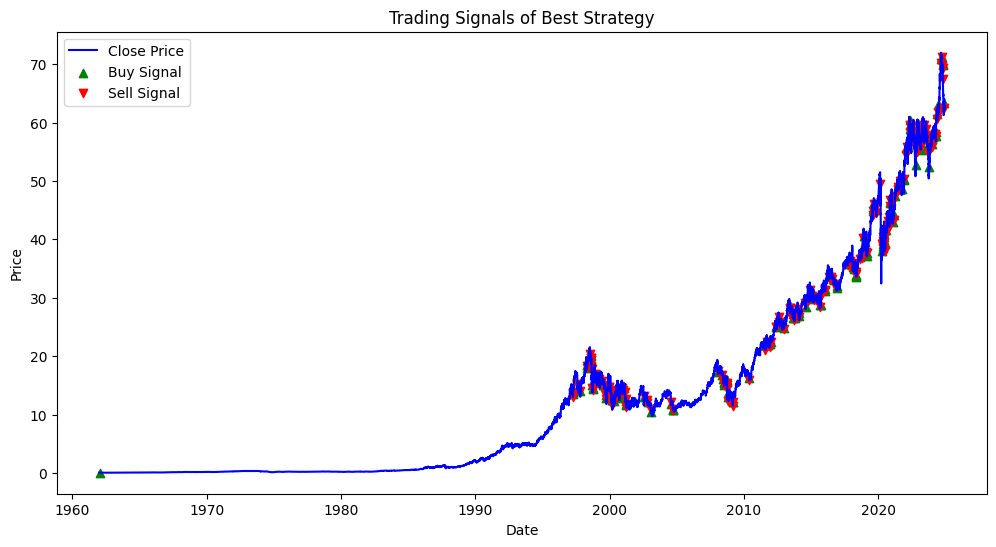

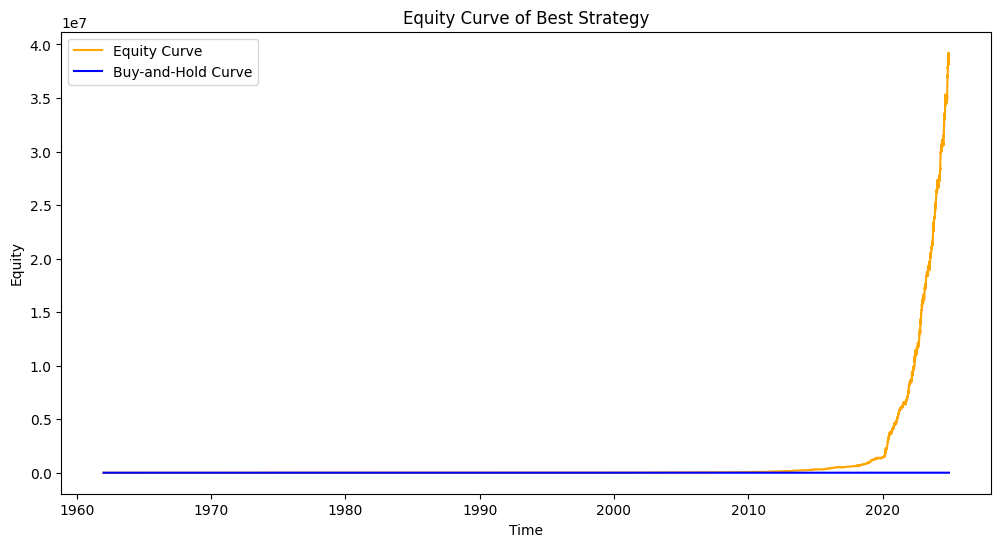

Profit of the strategy: 38689115.110452056
Sharpe of the strategy 9.705631574126118
Max Drawdown of the strategy nan


<ipython-input-77-1f6dd083973e>:56: RuntimeWarning: divide by zero encountered in divide
  drawdown = (peak - equity_curve) / peak
<ipython-input-77-1f6dd083973e>:56: RuntimeWarning: invalid value encountered in divide
  drawdown = (peak - equity_curve) / peak


In [ ]:
ticker = "KO"
test_data = yf.Ticker(ticker).history(period="max")
test_data['Adjusted Close'] = test_data['Close'] + test_data['Dividends'].cumsum()

# Precompute Indicators
precomputed_features = []
for i, indicator in enumerate(feature_set):
    # Generate all parameter combinations
    param_combinations = [dict(zip(feature_set[indicator]['params'], values))
                         for values in itertools.product(*feature_set[indicator]['params'].values())]

    for params in param_combinations:  # Iterate through combinations
        precomputed_features.append(apply_indicator(indicator, test_data, params))

test_features = np.column_stack(precomputed_features)  # Combine all features

test_predictions = []
for row in test_features:
    test_prediction = best_strategy_function(*row)
    # Ensure prediction is a scalar
    test_prediction = float(test_prediction)  # Convert to scalar if necessary
    threshold_buy, threshold_sell = 0.01, -0.01
    if test_prediction > threshold_buy:
        test_predictions.append(1)  # Buy
    elif test_prediction < threshold_sell:
        test_predictions.append(-1)  # Sell
    else:
        test_predictions.append(0)  # Hold

test_data['Prediction'] = pd.Series(test_predictions, index=test_data.index)
test_data['Prediction'].shift(1)
test_data['Prediction'].fillna(0, inplace=True)  # Fill NaN (introduced by shift) with 0
test_data['Prediction'] = test_data['Prediction'].astype(int)  # Convert to integer type
print(test_data['Prediction'].value_counts())
print("Trades:", test_data['Prediction'].diff().value_counts())

plot_df = test_data[['Close']].copy()  # Start with closing prices
plot_df['Signal'] = test_data[['Prediction']].diff().copy()  # Add the trading signals
# Add any other columns you want to visualize (e.g., indicators)

plt.figure(figsize=(12, 6))
plt.plot(plot_df['Close'], label='Close Price', color='blue')
plt.scatter(plot_df.index[plot_df['Signal'] > 0], plot_df['Close'][plot_df['Signal'] > 0], marker='^', color='green', label='Buy Signal')
#plt.scatter(plot_df.index[plot_df['Signal'] == 0], plot_df['Close'][plot_df['Signal'] == 0], marker='o', color='blue', label='No Signal')
plt.scatter(plot_df.index[plot_df['Signal'] < 0], plot_df['Close'][plot_df['Signal'] < 0], marker='v', color='red', label='Sell Signal')
plt.title('Trading Signals of Best Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

equity_curve = (np.array(test_data['Prediction'] * test_data['Close'].pct_change()))
equity_curve[np.isnan(equity_curve)] = 0
test_data.loc[:, 'Cumulative Return'] = (1 + equity_curve).cumprod()

test_data['Buy-and-Hold'] = test_data['Adjusted Close'] / test_data['Adjusted Close'].iloc[0]

plt.figure(figsize=(12, 6))
#plt.plot(test_data['Target Cumulative Return'], label='Target Curve', color='red')
plt.plot(test_data['Cumulative Return'], label='Equity Curve', color='orange')
plt.plot(test_data['Buy-and-Hold'], label='Buy-and-Hold Curve', color='blue')
plt.title('Equity Curve of Best Strategy')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.legend()
plt.show()

test_prices = test_data['Close'].values

print("Profit of the strategy:", test_data['Cumulative Return'].iloc[-1])
print("Sharpe of the strategy", calculate_sharpe_ratio(equity_curve, test_prices))
print("Max Drawdown of the strategy", calculate_max_drawdown(equity_curve))

# Step 14: Visualize last Year Prediction Values

<ipython-input-83-cc6d127f8665>:1: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_year_data = data.last('1Y')
<ipython-input-83-cc6d127f8665>:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  last_year_data = data.last('1Y')
<ipython-input-83-cc6d127f8665>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_year_data['Prediction'] = pd.Series(last_year_predictions, index=last_year_data.index)
<ipython-input-83-cc6d127f8665>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inpl

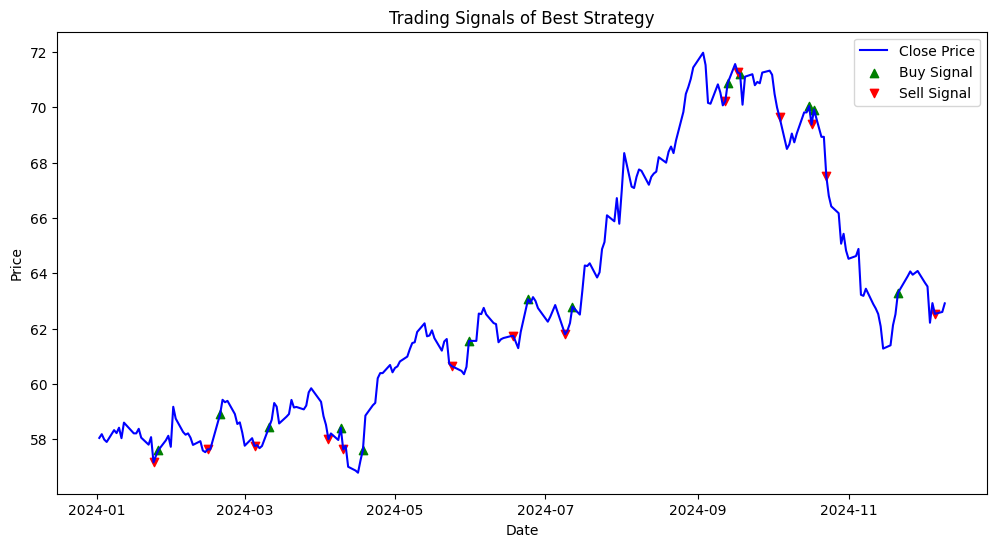

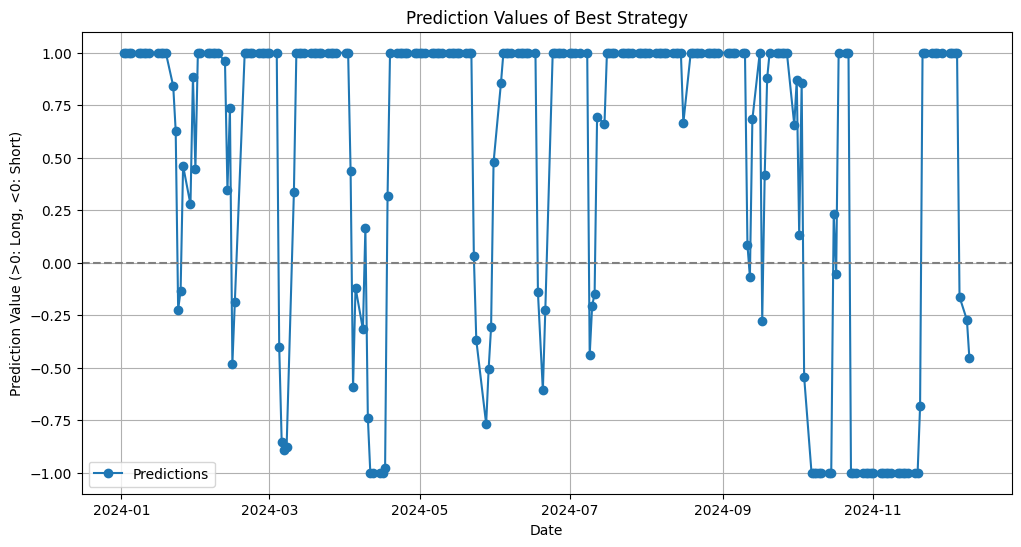

In [ ]:
last_year_data = data.last('1Y')

last_year_indices = last_year_data.index.get_indexer(data.index)  # Original line - commented out
   # Alternatively, using the improved approach to avoid potential issues:
last_year_indices = data.index.get_indexer(last_year_data.index)  # Using the index of the filtered data

valid_indices = [i for i in last_year_indices if i != -1]  # Get valid index values
last_year_features = features[valid_indices]

prediction_values = []
last_year_predictions = []
for row in last_year_features:
    last_year_prediction = best_strategy_function(*row)
    last_year_prediction = float(last_year_prediction)  # Convert to scalar if necessary
    prediction_values.append(last_year_prediction)
    threshold_buy, threshold_sell = 0.01, -0.01
    if last_year_prediction > threshold_buy:
        last_year_predictions.append(1)  # Buy
    elif last_year_prediction < threshold_sell:
        last_year_predictions.append(-1)  # Sell
    else:
        last_year_predictions.append(0)  # Hold

last_year_data['Prediction'] = pd.Series(last_year_predictions, index=last_year_data.index)
last_year_data['Prediction'].shift(1)
last_year_data['Prediction'].fillna(0, inplace=True)  # Fill NaN (introduced by shift) with 0
last_year_data['Prediction'] = last_year_data['Prediction'].astype(int)  # Convert to integer type

plot_df = last_year_data[['Close']].copy()  # Start with closing prices
plot_df['Signal'] = last_year_data[['Prediction']].diff().copy()  # Add the trading signals
# Add any other columns you want to visualize (e.g., indicators)

plt.figure(figsize=(12, 6))
plt.plot(plot_df['Close'], label='Close Price', color='blue')
plt.scatter(plot_df.index[plot_df['Signal'] > 0], plot_df['Close'][plot_df['Signal'] > 0], marker='^', color='green', label='Buy Signal')
#plt.scatter(plot_df.index[plot_df['Signal'] == 0], plot_df['Close'][plot_df['Signal'] == 0], marker='o', color='blue', label='No Signal')
plt.scatter(plot_df.index[plot_df['Signal'] < 0], plot_df['Close'][plot_df['Signal'] < 0], marker='v', color='red', label='Sell Signal')
plt.title('Trading Signals of Best Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(last_year_data.index, prediction_values, label='Predictions', marker='o', linestyle='-')
plt.axhline(y=0, color='gray', linestyle='--')  # Add a horizontal line at y=0 for clarity
plt.title('Prediction Values of Best Strategy')
plt.xlabel('Date')
plt.ylabel('Prediction Value (>0: Long, <0: Short)')
plt.legend()
plt.grid(True)
plt.show()

# Step 15: Compare to NN

            0         1         2          3          4          5         6   \
0          NaN       NaN       NaN        NaN        NaN        NaN       NaN   
1          NaN       NaN       NaN        NaN        NaN        NaN       NaN   
2          NaN       NaN       NaN        NaN        NaN        NaN       NaN   
3          NaN       NaN       NaN        NaN        NaN        NaN       NaN   
4          NaN       NaN       NaN        NaN        NaN        NaN       NaN   
...        ...       ...       ...        ...        ...        ...       ...   
2461 -1.854103  0.091148 -2.667931  63.459921  62.972001  66.240637  0.641230   
2462 -1.025002  0.404156 -0.300499  63.500336  62.956976  66.080794  0.585423   
2463 -1.550003 -0.750046 -0.650799  63.425331  62.924436  65.914143  0.660072   
2464 -1.050003 -0.838840 -0.838840  63.341447  62.882494  65.741151  0.709607   
2465 -0.610001 -0.985374  0.026943  63.242910  62.883842  65.572970  0.692347   

            7         8    

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.3294 - loss: -1.2919 - val_accuracy: 0.3963 - val_loss: -1.7782
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3343 - loss: -1.6073 - val_accuracy: 0.3050 - val_loss: -1.8246
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3571 - loss: -1.7708 - val_accuracy: 0.3402 - val_loss: -1.8332
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3153 - loss: -1.8490 - val_accuracy: 0.4066 - val_loss: -1.8368
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3252 - loss: -1.8367 - val_accuracy: 0.4606 - val_loss: -1.8371
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3522 - loss: -1.9053 - val_accuracy: 0.3465 - val_loss: -1.8332
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3281 - loss: -1.8336 - val_accuracy: 0.3880 - val_loss: -1.8293
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3482 - loss: -1.8137 - val_accuracy: 0.3755 - val_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
NN predictions:  [[0.19938321 0.07961418 0.7210025 ]
 [0.19179685 0.10439693 0.7038062 ]
 [0.1596395  0.08658654 0.75377405]
 ...
 [0.33177066 0.33081055 0.33741874]
 [0.33741015 0.3272233  0.33536658]
 [0.33177066 0.33081055 0.33741874]]
NN Predictions value counts: 2    14340
1      834
0      368
Name: count, dtype: int64
Test accuracy: 0.3089049028439068
NN Strategy returns: [ 1.         -0.01546332  0.00519566 ...  0.00223892  0.
 -0.00858371]
Plot_df Signals value count: Signal
 0.0    14352
-2.0      437
 2.0      436
 1.0      159
-1.0      157
Name: count, dtype: int64


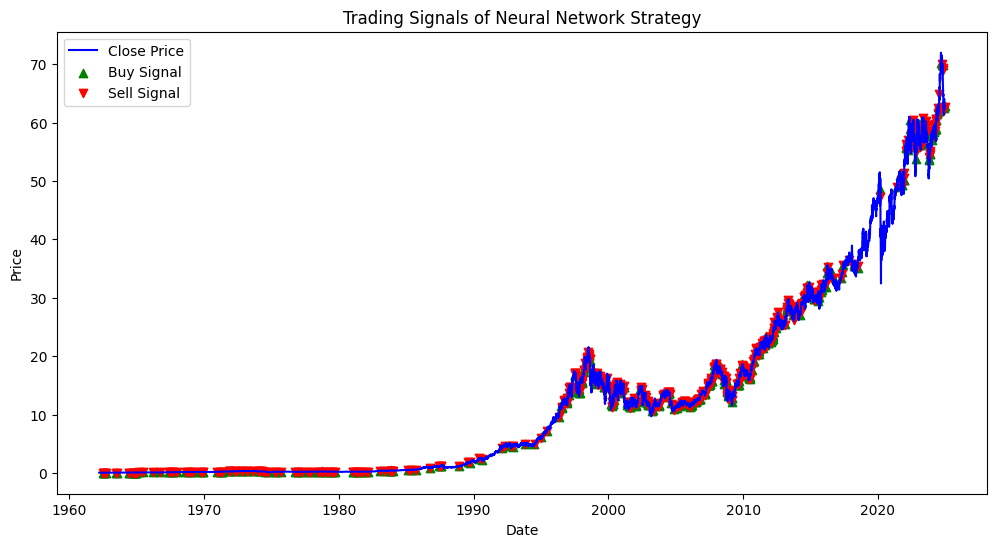

  Model  Accuracy  Sharpe Ratio  Drawdown
0    GP  0.354675      5.029108  0.369875
1    NN  0.308905      3.727261  0.493827


In [ ]:
from sklearn.model_selection import train_test_split

# 1. Convert 'features' to a Pandas DataFrame
features_df = pd.DataFrame(features)
print(features_df)
# 2. Concatenate 'features_df' and 'data['Target']'
# Drop rows with NaN values (resulting from moving averages)
data.dropna(inplace=True)
features_df = features_df.set_index(data.index)
print(features_df.index)
print(data['Target'].index)
concatenated_df = features_df.reindex(data.index).join(data['Target'])
print(concatenated_df)
# 3. Remove rows with NaN values
cleaned_df = concatenated_df.dropna()
print(cleaned_df)
# Extract features (all columns except the last one, which is the target)
features_extracted = cleaned_df.iloc[:, :-1].values

# Extract target variable (the last column)
target_extracted = cleaned_df.iloc[:, -1].values

X = features_extracted
y = target_extracted
print(len(X), len(y))
# Map target values to 0, 1, 2
y = np.where(y == -1, 0, np.where(y == 0, 1, 2))  # -1: sell, 0: hold, 1: buy
y_series = pd.Series(y) # Convert y to pandas Series
print(y_series.value_counts())
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)  # Apply to both training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y_series, test_size=0.2, random_state=42)  # 80% train, 20% test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 60% train, 20% val, 20% test

import numpy as np

# Check for NaN or infinite values in the features
print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in X_val:", np.isnan(X_val).sum())
print("NaN in X_test:", np.isnan(X_test).sum())

print("Infinite in X_train:", np.isinf(X_train).any())
print("Infinite in X_val:", np.isinf(X_val).any())
print("Infinite in X_test:", np.isinf(X_test).any())

import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),  # Dropout for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 output classes
])

import tensorflow as tf

def negative_sharpe_loss(y_true, y_pred):
  """
  Calculates the negative Sharpe ratio as a loss function.

  Args:
    y_true: The true target values (daily returns).
    y_pred: The predicted trading signals (1 for buy, -1 for sell, 0 for hold).

  Returns:
    The negative Sharpe ratio.
  """
  strategy_returns = y_pred * y_true  # Element-wise multiplication
  avg_return = tf.reduce_mean(strategy_returns)
  std_dev = tf.math.reduce_std(strategy_returns)
  sharpe_ratio = avg_return / (std_dev + 1e-8)  # Add small epsilon to avoid division by zero
  return -sharpe_ratio  # Return negative for minimization


model.compile(optimizer='adam',
                  loss=negative_sharpe_loss,
                  metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[callback]  )

from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(model.predict(X_test), axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Insert test_features and test_data['Target']

# Parameters for Moving Averages and Threshold
short_window = 30  # Short-term moving average window
long_window = 50   # Long-term moving average window
threshold = 0.001  # 0.1% threshold for significant price change

# Calculate Moving Averages
test_data['Short_MA'] = test_data['Close'].rolling(window=short_window).mean()
test_data['Long_MA'] = test_data['Close'].rolling(window=long_window).mean()

# Identify Trends Using Moving Averages
test_data['Trend'] = np.where(test_data['Short_MA'] > test_data['Long_MA'], 1, -1)  # 1 for uptrend, -1 for downtrend

# Calculate Percentage Price Change
test_data['Price_Change'] = (test_data['Close'].shift(-1) - test_data['Close']) / test_data['Close']

# Define Target Using Trend and Threshold
test_data['Target'] = np.where(
    (test_data['Trend'] == 1) & (test_data['Price_Change'] > threshold), 1,   # Buy signal for uptrend and significant price increase
    np.where(
        (test_data['Trend'] == -1) & (test_data['Price_Change'] < -threshold), -1,  # Sell signal for downtrend and significant price decrease
        0  # Hold for small changes or conflicting signals
    )
)

# Calculate naive strategy metrics
test_data['Target Return'] = data['Target'].shift(1) * data['Daily Return']
test_data['Target Cumulative Return'] = (1 + data['Target Return']).cumprod()

test_features_df = pd.DataFrame(test_features)
test_features_df = test_features_df.set_index(test_data.index)

test_data['Target'] = np.where(test_data['Target'] == -1, 0, np.where(test_data['Target'] == 0, 1, 2))  # -1: sell, 0: hold, 1: buy

concatenated_test_df = test_features_df.reindex(test_data.index).join(test_data[['Close', 'Target']])

cleaned_test_df = concatenated_test_df.dropna()
print(cleaned_test_df)

test_features_extracted = cleaned_test_df.iloc[:, :-2].values

test_target_extracted = cleaned_test_df.iloc[:, -1].values

from sklearn.metrics import accuracy_score

nn_predictions = model.predict(test_features_extracted)
print("NN predictions: ", nn_predictions)
nn_predictions = np.argmax(nn_predictions, axis=1)  # Get predicted class labels
# Convert nn_predictions to a pandas Series before calling value_counts()
nn_predictions_series = pd.Series(nn_predictions)
print("NN Predictions value counts:", nn_predictions_series.value_counts())
# Calculate accuracy using accuracy_score
nn_accuracy = accuracy_score(test_target_extracted, nn_predictions)
print('Test accuracy:', nn_accuracy)
nn_returns = np.array(nn_predictions * cleaned_test_df['Close'].pct_change())
nn_returns[np.isnan(nn_returns)] = 1
print("NN Strategy returns:", nn_returns)
nn_sharpe = calculate_sharpe_ratio(nn_returns, prices)
nn_drawdown = calculate_max_drawdown(nn_returns)

signal_mapping = {
    0: 0,
    1: 1,
    2: -1
}

signals = pd.Series(np.vectorize(signal_mapping.get)(nn_predictions), index=cleaned_test_df.index) # Assign index here

plot_df = pd.DataFrame({'Close': cleaned_test_df['Close'].copy()}) # Create DataFrame with index
plot_df['Signal'] = signals.diff()  # Add the trading signals
# Add any other columns you want to visualize (e.g., indicators)
print("Plot_df Signals value count:", plot_df['Signal'].value_counts())
plt.figure(figsize=(12, 6))
plt.plot(plot_df['Close'], label='Close Price', color='blue')
plt.scatter(plot_df.index[plot_df['Signal'] > 0], plot_df['Close'][plot_df['Signal'] > 0], marker='^', color='green', label='Buy Signal')
#plt.scatter(plot_df.index[plot_df['Signal'] == 0], plot_df['Close'][plot_df['Signal'] == 0], marker='o', color='blue', label='No Signal')
plt.scatter(plot_df.index[plot_df['Signal'] < 0], plot_df['Close'][plot_df['Signal'] < 0], marker='v', color='red', label='Sell Signal')
plt.title('Trading Signals of Neural Network Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

results = pd.DataFrame({
    'Model': ['GP', 'NN'],
    'Accuracy': [improved_ind.fitness.values[0], nn_accuracy],
    'Sharpe Ratio': [improved_sharpe, nn_sharpe],
    'Drawdown': [improved_ind.fitness.values[2], nn_drawdown],
})
print(results)

# Step 16: Compare to Support Vector Machine

SVM predictions:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 0 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 1]
SVM

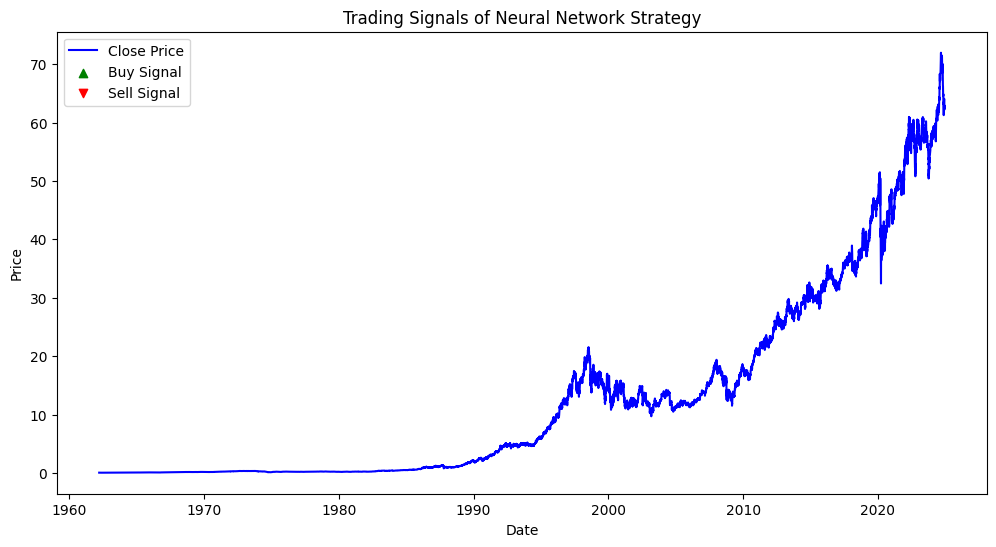

  Model  Accuracy  Sharpe Ratio  Drawdown
0    GP  0.354675      5.029108  0.369875
1   SVM  0.536610      4.030311  0.246914


In [ ]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel="rbf")  # You can experiment with different kernels

svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)
print("SVM predictions: ", y_pred)
print("SVM Predictions value counts:", pd.Series(y_pred).value_counts())

from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

svm_predictions = svm_classifier.predict(test_features_extracted)
print("SVM predictions: ", svm_predictions)
print("SVM Predictions value counts:", pd.Series(svm_predictions).value_counts())
svm_accuracy = accuracy_score(test_target_extracted, svm_predictions)
print('Test accuracy:', svm_accuracy)
svm_returns = np.array(svm_predictions * cleaned_test_df['Close'].pct_change())
svm_returns[np.isnan(svm_returns)] = 1
print("SVM Strategy returns:", svm_returns)
svm_sharpe = calculate_sharpe_ratio(svm_returns, prices)
svm_drawdown = calculate_max_drawdown(svm_returns)

signal_mapping = {
    0: 0,
    1: 1,
    2: -1
}

signals = pd.Series(np.vectorize(signal_mapping.get)(svm_predictions), index=cleaned_test_df.index) # Assign index here

plot_df = pd.DataFrame({'Close': cleaned_test_df['Close'].copy()}) # Create DataFrame with index
plot_df['Signal'] = signals.diff()  # Add the trading signals
# Add any other columns you want to visualize (e.g., indicators)
print("Plot_df Signals value count:", plot_df['Signal'].value_counts())
plt.figure(figsize=(12, 6))
plt.plot(plot_df['Close'], label='Close Price', color='blue')
plt.scatter(plot_df.index[plot_df['Signal'] > 0], plot_df['Close'][plot_df['Signal'] > 0], marker='^', color='green', label='Buy Signal')
#plt.scatter(plot_df.index[plot_df['Signal'] == 0], plot_df['Close'][plot_df['Signal'] == 0], marker='o', color='blue', label='No Signal')
plt.scatter(plot_df.index[plot_df['Signal'] < 0], plot_df['Close'][plot_df['Signal'] < 0], marker='v', color='red', label='Sell Signal')
plt.title('Trading Signals of Neural Network Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

results = pd.DataFrame({
    'Model': ['GP', 'SVM'],
    'Accuracy': [improved_ind.fitness.values[0], svm_accuracy],
    'Sharpe Ratio': [improved_sharpe, svm_sharpe],
    'Drawdown': [improved_ind.fitness.values[2], svm_drawdown],
})
print(results)

# Step 17: Compare to Random Forest

RF predictions:  [1 1 1 1 1 1 1 1 1 2 2 1 1 1 2 1 2 1 1 1 1 1 0 2 1 1 2 1 1 0 1 1 0 1 1 0 1
 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 2 1 0 1 2 0 1 1 1 1 1 2 1 1 2 1
 1 1 1 2 1 2 1 1 1 1 0 2 1 1 2 1 1 1 2 2 0 1 2 1 0 1 2 1 1 1 1 1 2 1 0 2 1
 2 1 1 1 1 1 1 1 1 2 1 0 1 1 1 2 1 1 1 1 2 0 1 1 1 2 1 1 2 1 1 1 0 1 1 1 0
 1 0 1 1 1 2 1 1 1 1 1 2 1 1 0 1 1 1 1 2 1 1 1 1 0 2 1 1 1 1 2 1 2 1 1 2 2
 2 1 1 2 2 1 1 1 1 2 1 1 1 1 1 2 1 0 1 1 1 0 0 1 2 1 1 1 0 1 0 1 1 1 1 2 1
 1 2 2 2 1 1 1 1 1 0 2 1 1 1 2 1 2 1 1 1 2 1 1 1 2 2 1 1 2 1 1 2 1 1 2 1 2
 2 2 1 1 0 1 1 2 2 1 1 2 0 2 1 1 1 2 1 1 1 2 1 1 0 2 1 1 1 2 1 0 2 1 1 1 1
 2 2 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 0 1 1 0 1 2 2 1 2 1 2 1 1 2 1 1 2 0 2 2
 1 1 1 0 1 2 1 1 1 1 1 1 1 0 1 1 1 2 1 0 2 1 1 1 0 0 2 1 1 1 1 0 2 0 1 1 2
 1 1 1 2 1 1 1 1 1 1 2 1 1 2 2 1 2 1 1 1 2 2 1 1 2 1 2 1 1 1 2 1 1 2 0 2 1
 1 0 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 1 1 1 1 2 1 2 1 1 1 1 2 2 1 1 1 2 1 1
 1 1 0 1 2 1 1 2 2 1 2 1 0 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 1 1 0 1
 1]
RF P

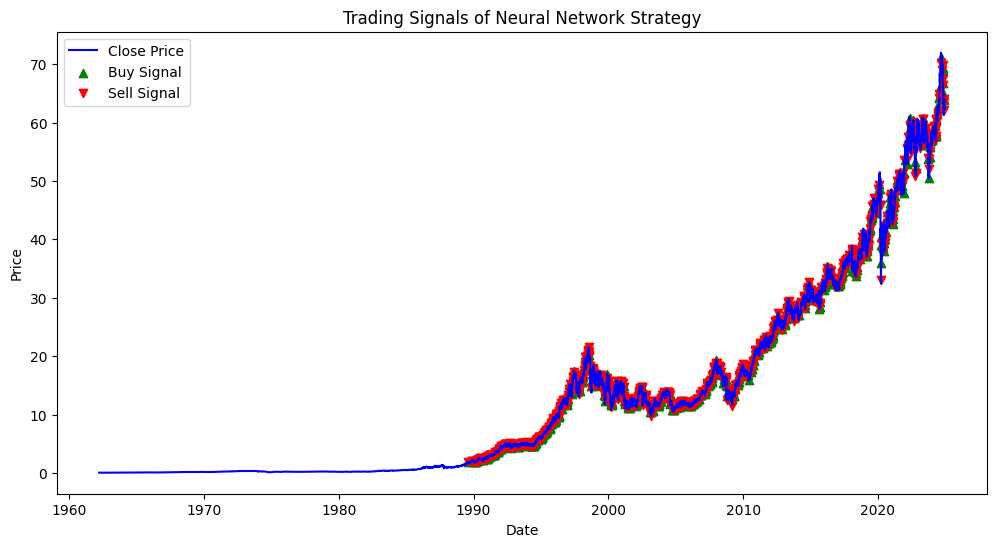

  Model  Accuracy  Sharpe Ratio  Drawdown
0    GP  0.354675      5.029108  0.369875
1    RF  0.489126      3.234233  0.246914


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# Adjust hyperparameters like n_estimators as needed
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
print("RF predictions: ", y_pred)
print("RF Predictions value counts:", pd.Series(y_pred).value_counts())

from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

rf_predictions = rf_classifier.predict(test_features_extracted)
print("RF predictions: ", rf_predictions)
print("RF Predictions value counts:", pd.Series(rf_predictions).value_counts())
rf_accuracy = accuracy_score(test_target_extracted, rf_predictions)
print('Test accuracy:', rf_accuracy)
rf_returns = np.array(rf_predictions * cleaned_test_df['Close'].pct_change())
rf_returns[np.isnan(rf_returns)] = 1
print("RF Strategy returns:", rf_returns)
rf_sharpe = calculate_sharpe_ratio(rf_returns, prices)
rf_drawdown = calculate_max_drawdown(rf_returns)

signal_mapping = {
    0: 0,
    1: 1,
    2: -1
}

signals = pd.Series(np.vectorize(signal_mapping.get)(rf_predictions), index=cleaned_test_df.index) # Assign index here

plot_df = pd.DataFrame({'Close': cleaned_test_df['Close'].copy()}) # Create DataFrame with index
plot_df['Signal'] = signals.diff()  # Add the trading signals
# Add any other columns you want to visualize (e.g., indicators)
print("Plot_df Signals value count:", plot_df['Signal'].value_counts())
plt.figure(figsize=(12, 6))
plt.plot(plot_df['Close'], label='Close Price', color='blue')
plt.scatter(plot_df.index[plot_df['Signal'] > 0], plot_df['Close'][plot_df['Signal'] > 0], marker='^', color='green', label='Buy Signal')
#plt.scatter(plot_df.index[plot_df['Signal'] == 0], plot_df['Close'][plot_df['Signal'] == 0], marker='o', color='blue', label='No Signal')
plt.scatter(plot_df.index[plot_df['Signal'] < 0], plot_df['Close'][plot_df['Signal'] < 0], marker='v', color='red', label='Sell Signal')
plt.title('Trading Signals of Neural Network Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

results = pd.DataFrame({
    'Model': ['GP', 'RF'],
    'Accuracy': [improved_ind.fitness.values[0], rf_accuracy],
    'Sharpe Ratio': [improved_sharpe, rf_sharpe],
    'Drawdown': [improved_ind.fitness.values[2], rf_drawdown],
})
print(results)

# Step 18: Compare all together

NN Strategy returns: 14427
SVM Strategy returns: 14778
RF Strategy returns: 14283
GP Strategy returns: 15845
NN Strategy Cumulative Return: 5584.995457546235
SVM Strategy Cumulative Return: 2794.332065551517
RF Strategy Cumulative Return: 761.5800221447814
GP Strategy Cumulative Return: 38689115.110452056


<ipython-input-167-72e3f9578df1>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("GP Strategy Cumulative Return:", test_data['Cumulative Return'][-1])


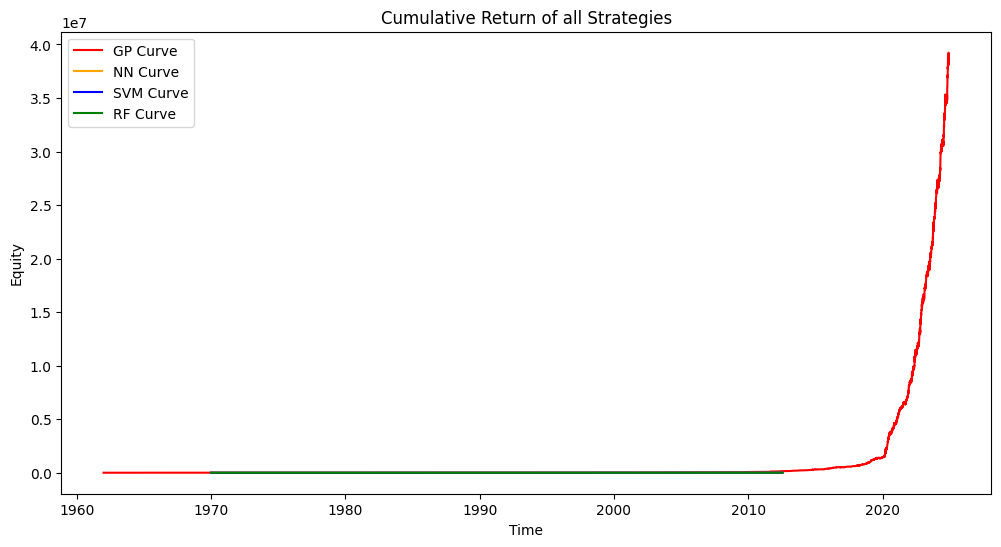

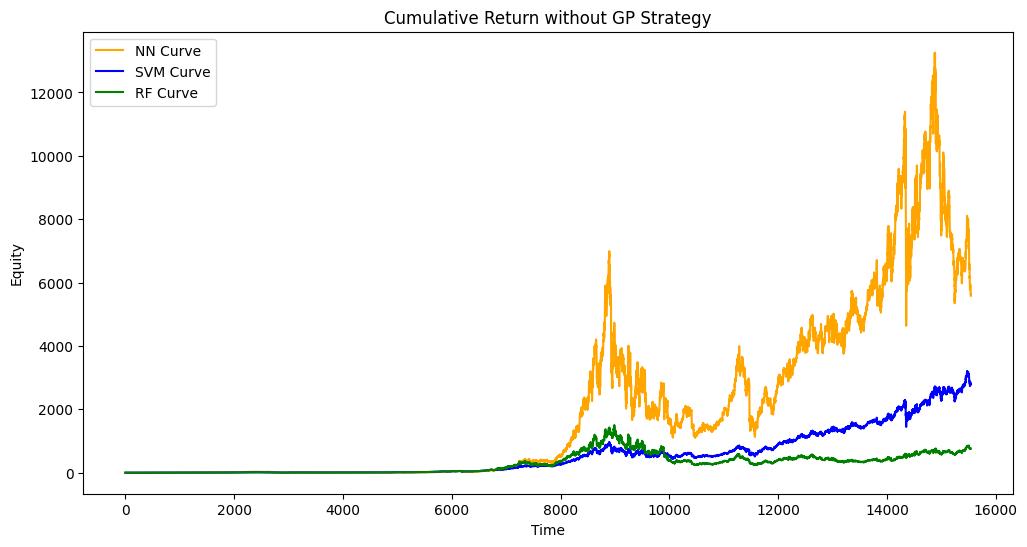

In [ ]:
#test_data.loc[:, 'NN Cumulative Return'] = (1 + nn_returns).cumprod()
#test_data.loc[:, 'SVM Cumulative Return'] = (1 + svm_returns).cumprod()
#test_data.loc[:, 'RF Cumulative Return'] = (1 + rf_returns).cumprod()

print("NN Strategy returns:", np.count_nonzero(nn_returns))
print("SVM Strategy returns:", np.count_nonzero(svm_returns))
print("RF Strategy returns:", np.count_nonzero(rf_returns))
print("GP Strategy returns:", np.count_nonzero(test_data['Cumulative Return']))
print("NN Strategy Cumulative Return:", (1 + nn_returns).cumprod()[-1])
print("SVM Strategy Cumulative Return:", (1 + svm_returns).cumprod()[-1])
print("RF Strategy Cumulative Return:", (1 + rf_returns).cumprod()[-1])
print("GP Strategy Cumulative Return:", test_data['Cumulative Return'][-1])

plt.figure(figsize=(12, 6))
plt.plot(test_data['Cumulative Return'], label='GP Curve', color='red')
plt.plot((1 + nn_returns).cumprod(), label='NN Curve', color='orange')
plt.plot((1 + svm_returns).cumprod(), label='SVM Curve', color='blue')
plt.plot((1 + rf_returns).cumprod(), label='RF Curve', color='green')
plt.title('Cumulative Return of all Strategies')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot((1 + nn_returns).cumprod(), label='NN Curve', color='orange')
plt.plot((1 + svm_returns).cumprod(), label='SVM Curve', color='blue')
plt.plot((1 + rf_returns).cumprod(), label='RF Curve', color='green')
plt.title('Cumulative Return without GP Strategy')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.legend()
plt.show()